#### Dictionary coverage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
import statistics
from matplotlib.patches import FancyArrow
import json

plt.rcParams['figure.dpi'] = 900

# 将X/Y轴的刻度线方向设置向内
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 设置字体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Microsoft Yahei'

# 设置公式字体
config = {
    "mathtext.fontset": 'stix',
}
rcParams.update(config)

#### 频率差异比较(GBNC vs C4EL)

In [2]:
def get_appear_times_per_10():
    df_gbnc = pd.read_csv('./data/languages_smoothing(8)/English_latin frequency(2135)_smoothing(8).csv')
    df_total_words = pd.read_csv('./data/appear times(1800-2019)/English/total words(1800-2019).csv')

    apper_times_in_gbnc_total = []
    for stay, endy in zip(range(1800, 2011, 10), range(1810, 2021, 10)):
        # print(stay, endy)
        apper_times_in_gbnc = {}
        for col in df_gbnc.columns[1:]:
            if list(df_gbnc[col]) == [0] * len(df_gbnc[col]):
                continue
            # 讨论近10年的平均出现次数 2009-2019
            index_grams = str(len(col.split(' '))) + '-grams'
            apper_times_list = []
            # 使用进10年的平均出现次数
            # for freq, number_of_words in zip(df_gbnc[col][-21:-1], df_total_words[index_grams][-11:-1]):
            for freq, number_of_words in zip(df_gbnc[col][stay-1500:endy-1500], df_total_words[index_grams][stay-1800:endy-1800]):
                apper_times_list.append(freq * number_of_words)
            apper_times_in_gbnc[col] = int(np.average(apper_times_list))
        apper_times_in_gbnc_total.append(apper_times_in_gbnc)

    df_appear_times = pd.read_csv('./data/data analysis v2.0/latin phrase in data v2.0.csv')
    appear_times_in_LE = {}
    for pha, times in zip(df_appear_times['phrase'], df_appear_times['appear times']):
        appear_times_in_LE[pha] = times
    return apper_times_in_gbnc_total, appear_times_in_LE


def get_rates_per_10():
    apper_times_in_gbnc_total, appear_times_in_LE = get_appear_times_per_10()
    rates = []
    for apper_times_in_gbnc in apper_times_in_gbnc_total:
        # 在两个数据集中都存在的词组
        all_in = []
        for phrase_in_gbnc in apper_times_in_gbnc.keys():
            if phrase_in_gbnc in appear_times_in_LE.keys():
                all_in.append((phrase_in_gbnc, apper_times_in_gbnc[phrase_in_gbnc], appear_times_in_LE[phrase_in_gbnc]))

        analyse_phrases = []    # 用于绘图的词组
        x_gbnc, y_LE = [], []
        for ele in all_in:
            p, g, l = ele
            # 出现次数少于100，可以被当做是噪声，不应该纳入讨论
            if g < 100 or l < 100:
                continue
            analyse_phrases.append(p)
            x_gbnc.append(g)
            y_LE.append(l)
        # print('绘图的词组数量：', len(analyse_phrases))

        # 在双对数坐标中，计算指数，与 Michel 2007类似
        coeffs = np.polyfit(np.log10(x_gbnc), np.log10(y_LE), 1)
        [slope, intercept] = coeffs
        # print('拟合曲线：', slope, intercept)
        x_values = [6e1, 1e6]
        y_sim_count = 10**(slope*np.log10(x_values) + intercept)
        # 计算点到直线的距离
        dis_list = []
        for point_x, point_y in zip(x_gbnc, y_LE):
            log_point_x = np.log10(point_x)
            log_point_y = np.log10(point_y)
            distance = np.abs(slope * log_point_x - log_point_y + intercept) / np.sqrt(slope ** 2 + 1)
            dis_list.append(distance)
        # print(dis_list)
        off_center_phrases = []
        edge_value = 0.5
        for pha, dis in zip(analyse_phrases, dis_list):
            # 将大于某个数值（偏离程度较大）的词组标出来
            if dis > edge_value:
                off_center_phrases.append(pha)
        # print('偏离中心的词组：', off_center_phrases)
        # 偏离中心的词组    

        # 绘制一条向下平移的直线
        # edge_value/np.cos(np.arctan(slope)): 截距与点到直线的距离不一样，需要转换
        b_upward = intercept + edge_value/np.cos(np.arctan(slope))
        y_upward = 10**(slope*np.log10(x_values) + b_upward)
        b_downward = intercept - edge_value/np.cos(np.arctan(slope))
        y_downward = 10**(slope*np.log10(x_values) + b_downward)

        dis_ = np.abs(slope * np.log10(x_values[1]) - np.log10(y_upward[1]) + intercept) / np.sqrt(slope ** 2 + 1)

        # print('距离：', dis_)

        # 绘制散点图的词组（不需要标注）
        scatter_x, scatter_y = [], []
        # 绘制散点图的词组（需要标注）
        scatter_off_x, scatter_off_y = [], []
        for pha, x, y in zip(analyse_phrases, x_gbnc, y_LE):
            # 选择未偏离中心的词组
            if pha in off_center_phrases:
                scatter_off_x.append(x)
                scatter_off_y.append(y)
            else:
                scatter_x.append(x)
                scatter_y.append(y)
        # print(len(scatter_off_x), len(scatter_x))
        rates.append(len(scatter_x)/(len(scatter_off_x)+len(scatter_x)))
    return rates

In [3]:
def plotSubpanel(ax):
    years = list(range(1800, 2020))
    sliced_year = [years[k:k+10] for k in range(0, len(years), 10)]
    X_, Y_ = [], []
    rates = get_rates_per_10()
    for ys, rate in zip(sliced_year, rates):
        X_.append(np.median(ys))
        Y_.append(rate)
    
    ax.margins(0)
    ax.plot(X_, Y_, color='#6671b5', linewidth=1.5, alpha=0.7, marker='o', markersize=4)

    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlim(1800, 2020)
    ax.set_ylim(0.5, 0.96)
    ax.set_xticks([1800, 1900, 1950, 2019])
    ax.set_xlabel('Decade', fontsize=10)
    ax.set_ylabel('Ratio (Covered)', fontsize=10)
    
    ax.axhline(0.8, color='#6d6e70', linewidth=2, linestyle='--', dashes=(1, 1), alpha=0.8)
    # ax.axvline(1950, color='#6d6e70', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
    # ax.tick_params(top='on', right='on', which='both')
    ax.axvspan(1950, 2019, alpha=0.5, color='#fac0ae', linewidth=0)

In [4]:
df_gbnc = pd.read_csv('./data/languages_smoothing(8)/English_latin frequency(2135)_smoothing(8).csv')
df_total_words = pd.read_csv('./data/appear times(1800-2019)/English/total words(1800-2019).csv')
print(df_gbnc.shape, df_total_words.shape)
apper_times_in_gbnc = {}
for col in df_gbnc.columns[1:]:
    if list(df_gbnc[col]) == [0] * len(df_gbnc[col]):
        continue
    # 讨论近10年的平均出现次数 2009-2019
    index_grams = str(len(col.split(' '))) + '-grams'
    apper_times_list = []
    # 使用进20年的平均出现次数
    for freq, number_of_words in zip(df_gbnc[col][-11:-1], df_total_words[index_grams][-11:-1]):
        apper_times_list.append(freq * number_of_words)
    apper_times_in_gbnc[col] = int(np.average(apper_times_list))
    
print(len(apper_times_in_gbnc))
print(apper_times_in_gbnc.values())

df_appear_times = pd.read_csv('./data/data analysis v2.0/latin phrase in data v2.0.csv')
appear_times_in_LE = {}
for pha, times in zip(df_appear_times['phrase'], df_appear_times['appear times']):
    appear_times_in_LE[pha] = times

(520, 2136) (220, 5)
1793
dict_values([0, 58, 5118, 1044, 3, 2, 0, 9300, 293, 29, 40, 235, 197, 108, 37, 24, 18343, 132763, 429, 4, 26, 177, 84, 145, 349, 17, 10, 25, 15, 19970, 140, 81, 10, 24, 289, 358, 13, 24, 831, 6, 19, 13, 1, 9, 12, 85, 13, 4, 31, 26, 4, 43, 131, 9, 14, 999, 7216, 80, 11, 4445, 17, 76, 182, 43, 94, 905, 85, 5, 13, 19, 123, 368, 201, 14, 512, 402, 11, 137276, 5812, 248, 447, 9238, 1320, 4, 5427, 371, 67, 9605, 367, 102, 65, 23, 342, 38, 3555, 106, 73, 1, 25, 0, 100, 258, 582, 1, 2, 29, 68, 282, 572, 38, 3, 12314, 20, 413, 43, 12, 68, 1, 153, 40, 72, 39, 106, 5, 22, 33, 34, 2698, 65, 53, 45, 27, 24, 9, 13755, 17434, 28, 8, 2, 4, 5, 11, 11709, 4, 3, 68, 765, 20, 154, 3, 172, 343, 21, 18, 25, 83, 0, 14, 3171, 88, 185, 300, 15, 151, 0, 513, 1504, 18, 677, 41, 9, 69, 11, 166, 244, 445, 15, 5, 1, 669, 531, 10, 1, 2, 417, 38, 32, 62, 1579, 695, 6, 33, 285, 350, 0, 4, 3, 0, 92, 134, 339, 0, 1570, 114, 41, 19, 3, 72, 276, 978, 795, 2744, 507, 9, 356, 19, 50, 3, 5, 9, 24, 1

In [5]:
# 在两个数据集中都存在的词组
all_in = []
for phrase_in_gbnc in apper_times_in_gbnc.keys():
    if phrase_in_gbnc in appear_times_in_LE.keys():
        all_in.append((phrase_in_gbnc, apper_times_in_gbnc[phrase_in_gbnc], appear_times_in_LE[phrase_in_gbnc]))
# print('two dataset have:', len(all_in))

analyse_phrases = []    # 用于绘图的词组
x_gbnc, y_LE = [], []
for ele in all_in:
    p, g, l = ele
    # 出现次数少于100，可以被当做是噪声，不应该纳入讨论
    if g < 100 or l < 100:
        continue
    analyse_phrases.append(p)
    x_gbnc.append(g)
    y_LE.append(l)
print('绘图的词组数量：', len(analyse_phrases))


# 在双对数坐标中，计算指数，与 Michel 2007类似
coeffs = np.polyfit(np.log10(x_gbnc), np.log10(y_LE), 1)
[slope, intercept] = coeffs
print('拟合曲线：', slope, intercept)
x_values = [6e1, 1e6]
y_sim_count = 10**(slope*np.log10(x_values) + intercept)
# 计算点到直线的距离
dis_list = []
for point_x, point_y in zip(x_gbnc, y_LE):
    log_point_x = np.log10(point_x)
    log_point_y = np.log10(point_y)
    distance = np.abs(slope * log_point_x - log_point_y + intercept) / np.sqrt(slope ** 2 + 1)
    dis_list.append(distance)
# print(dis_list)
off_center_phrases = []
edge_value = 0.5
for pha, dis in zip(analyse_phrases, dis_list):
    # 将大于某个数值（偏离程度较大）的词组标出来
    if dis > edge_value:
        off_center_phrases.append(pha)
# print('偏离中心的词组：', off_center_phrases)
# 偏离中心的词组

# 绘制一条向下平移的直线
# edge_value/np.cos(np.arctan(slope)): 截距与点到直线的距离不一样，需要转换
b_upward = intercept + edge_value/np.cos(np.arctan(slope))
y_upward = 10**(slope*np.log10(x_values) + b_upward)
b_downward = intercept - edge_value/np.cos(np.arctan(slope))
y_downward = 10**(slope*np.log10(x_values) + b_downward)

dis_ = np.abs(slope * np.log10(x_values[1]) - np.log10(y_upward[1]) + intercept) / np.sqrt(slope ** 2 + 1)

# print('距离：', dis_)

# 绘制散点图的词组（不需要标注）
scatter_x, scatter_y = [], []
# 绘制散点图的词组（需要标注）
scatter_off_x, scatter_off_y = [], []
for pha, x, y in zip(analyse_phrases, x_gbnc, y_LE):
    # 选择未偏离中心的词组
    if pha in off_center_phrases:
        scatter_off_x.append(x)
        scatter_off_y.append(y)
    else:
        scatter_x.append(x)
        scatter_y.append(y)

print(len(scatter_off_x), len(scatter_x))

绘图的词组数量： 531
拟合曲线： 1.078534534027308 -0.4048689709325278
41 490


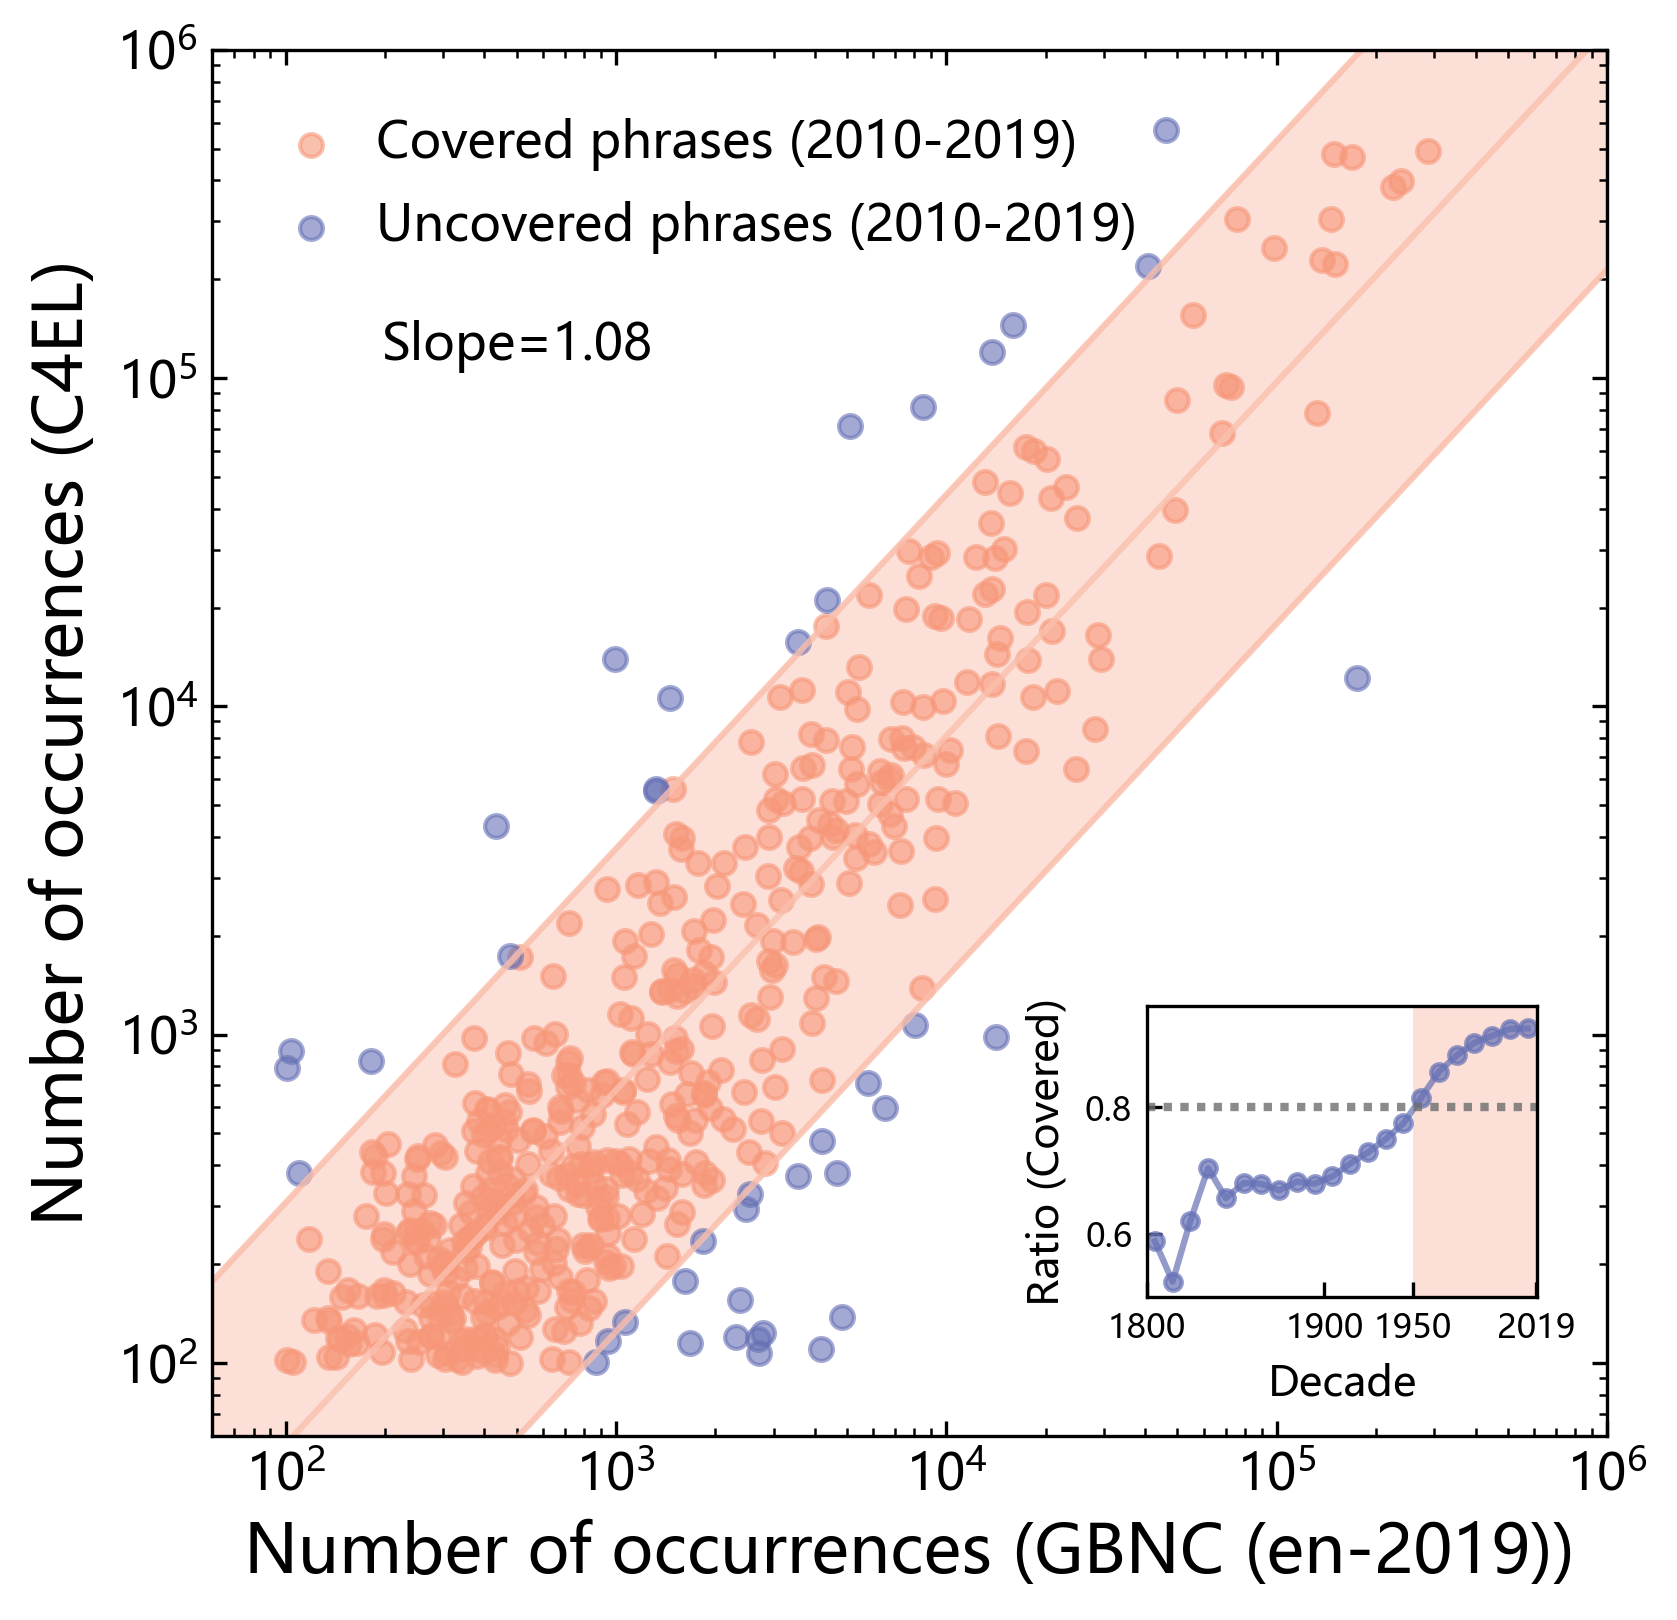

In [6]:
plt.rcParams['figure.dpi'] = 300
# 绘图
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#f79779', '#6671b5']
plt.yscale('log')
plt.xscale('log')

plt.plot(x_values, y_sim_count, color='#fac0ae', alpha=0.8, linewidth=1.5)
plt.plot(x_values, y_upward, color='#fac0ae', alpha=0.8, linewidth=1.5)
plt.plot(x_values, y_downward, color='#fac0ae', alpha=0.8, linewidth=1.5)
plt.fill_between(x_values, y_upward, y_downward, color='#fac0ae', alpha=0.5)
# 未偏离中心的词组
plt.scatter(scatter_x, scatter_y, s=30, c=colors[0], alpha=0.6, label='Covered phrases (2010-2019)')
# 偏离中心的词组
plt.scatter(scatter_off_x, scatter_off_y, s=30, c=colors[1], alpha=0.6, label='Uncovered phrases (2010-2019)')
plt.xlim(x_values[0], x_values[1])
plt.ylim(x_values[0], x_values[1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of occurrences (GBNC (en-2019))', fontsize=16)
plt.ylabel('Number of occurrences (C4EL)', fontsize=16)
plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.82), frameon=False, fontsize=12, labelspacing=0.6, handletextpad=0.5, handlelength=1.6)
plt.tick_params(top='on', right='on', which='both')
fig.text(0.219, 0.73, 'Slope='+"{:.2f}".format(slope), fontsize=12, va='top')

# 添加一个子图案例
sub_ax = ax.inset_axes([0.67, 0.1, 0.28, 0.21])
plotSubpanel(sub_ax)

In [8]:
# 原始数据
x_values = np.array([6e1, 1e6])
slope, intercept = [1.0733538741018214, -0.39004438811115427]

# 向下平移 0.5 后的截距
# b_new = intercept - np.sqrt(2)*0.5
b_new = intercept - 0.5/np.cos(np.arctan(slope))

# 计算向下平移后的直线上的点的坐标
y_downward = 10**(slope*np.log10(x_values) + b_new)

# 计算点到直线的距离
dis_downward = np.abs(slope * np.log10(x_values[0]) - np.log10(y_downward[0]) + intercept) / np.sqrt(slope ** 2 + 1)

print("向下平移距离:", dis_downward)

向下平移距离: 0.49999999999999994


#### GBNC 与 C4EL 的差异比较

In [9]:
df_gbnc = pd.read_csv('./data/languages_smoothing(8)/English_latin frequency(2135)_smoothing(8).csv')
df_total_words = pd.read_csv('./data/appear times(1800-2019)/English/total words(1800-2019).csv')

apper_times_in_gbnc_total = []
for stay, endy in zip(range(1800, 2011, 10), range(1810, 2021, 10)):
    # print(stay, endy)
    apper_times_in_gbnc = {}
    for col in df_gbnc.columns[1:]:
        if list(df_gbnc[col]) == [0] * len(df_gbnc[col]):
            continue
        # 讨论近10年的平均出现次数 2009-2019
        index_grams = str(len(col.split(' '))) + '-grams'
        apper_times_list = []
        # 使用进10年的平均出现次数
        # for freq, number_of_words in zip(df_gbnc[col][-21:-1], df_total_words[index_grams][-11:-1]):
        for freq, number_of_words in zip(df_gbnc[col][stay-1500:endy-1500], df_total_words[index_grams][stay-1800:endy-1800]):
            apper_times_list.append(freq * number_of_words)
        apper_times_in_gbnc[col] = int(np.average(apper_times_list))
    apper_times_in_gbnc_total.append(apper_times_in_gbnc)

df_appear_times = pd.read_csv('./data/data analysis v2.0/latin phrase in data v2.0.csv')
appear_times_in_LE = {}
for pha, times in zip(df_appear_times['phrase'], df_appear_times['appear times']):
    appear_times_in_LE[pha] = times

In [10]:
rates = []
for apper_times_in_gbnc in apper_times_in_gbnc_total:
    # 在两个数据集中都存在的词组
    all_in = []
    for phrase_in_gbnc in apper_times_in_gbnc.keys():
        if phrase_in_gbnc in appear_times_in_LE.keys():
            all_in.append((phrase_in_gbnc, apper_times_in_gbnc[phrase_in_gbnc], appear_times_in_LE[phrase_in_gbnc]))

    analyse_phrases = []    # 用于绘图的词组
    x_gbnc, y_LE = [], []
    for ele in all_in:
        p, g, l = ele
        # 出现次数少于100，可以被当做是噪声，不应该纳入讨论
        if g < 100 or l < 100:
            continue
        analyse_phrases.append(p)
        x_gbnc.append(g)
        y_LE.append(l)
    # print('绘图的词组数量：', len(analyse_phrases))

    # 在双对数坐标中，计算指数，与 Michel 2007类似
    coeffs = np.polyfit(np.log10(x_gbnc), np.log10(y_LE), 1)
    [slope, intercept] = coeffs
    # print('拟合曲线：', slope, intercept)
    x_values = [6e1, 1e6]
    y_sim_count = 10**(slope*np.log10(x_values) + intercept)
    # 计算点到直线的距离
    dis_list = []
    for point_x, point_y in zip(x_gbnc, y_LE):
        log_point_x = np.log10(point_x)
        log_point_y = np.log10(point_y)
        distance = np.abs(slope * log_point_x - log_point_y + intercept) / np.sqrt(slope ** 2 + 1)
        dis_list.append(distance)
    # print(dis_list)
    off_center_phrases = []
    edge_value = 0.5
    for pha, dis in zip(analyse_phrases, dis_list):
        # 将大于某个数值（偏离程度较大）的词组标出来
        if dis > edge_value:
            off_center_phrases.append(pha)
    # print('偏离中心的词组：', off_center_phrases)
    # 偏离中心的词组    

    # 绘制一条向下平移的直线
    # edge_value/np.cos(np.arctan(slope)): 截距与点到直线的距离不一样，需要转换
    b_upward = intercept + edge_value/np.cos(np.arctan(slope))
    y_upward = 10**(slope*np.log10(x_values) + b_upward)
    b_downward = intercept - edge_value/np.cos(np.arctan(slope))
    y_downward = 10**(slope*np.log10(x_values) + b_downward)

    dis_ = np.abs(slope * np.log10(x_values[1]) - np.log10(y_upward[1]) + intercept) / np.sqrt(slope ** 2 + 1)

    # print('距离：', dis_)

    # 绘制散点图的词组（不需要标注）
    scatter_x, scatter_y = [], []
    # 绘制散点图的词组（需要标注）
    scatter_off_x, scatter_off_y = [], []
    for pha, x, y in zip(analyse_phrases, x_gbnc, y_LE):
        # 选择未偏离中心的词组
        if pha in off_center_phrases:
            scatter_off_x.append(x)
            scatter_off_y.append(y)
        else:
            scatter_x.append(x)
            scatter_y.append(y)
    # print(len(scatter_off_x), len(scatter_x))
    rates.append(len(scatter_x)/(len(scatter_off_x)+len(scatter_x)))

[1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959] 0.815347721822542
[1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969] 0.8562231759656652
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979] 0.8821052631578947
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989] 0.9022403258655805
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999] 0.9132149901380671
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009] 0.9239543726235742
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 0.9246704331450094


Text(0, 0.5, 'Rate')

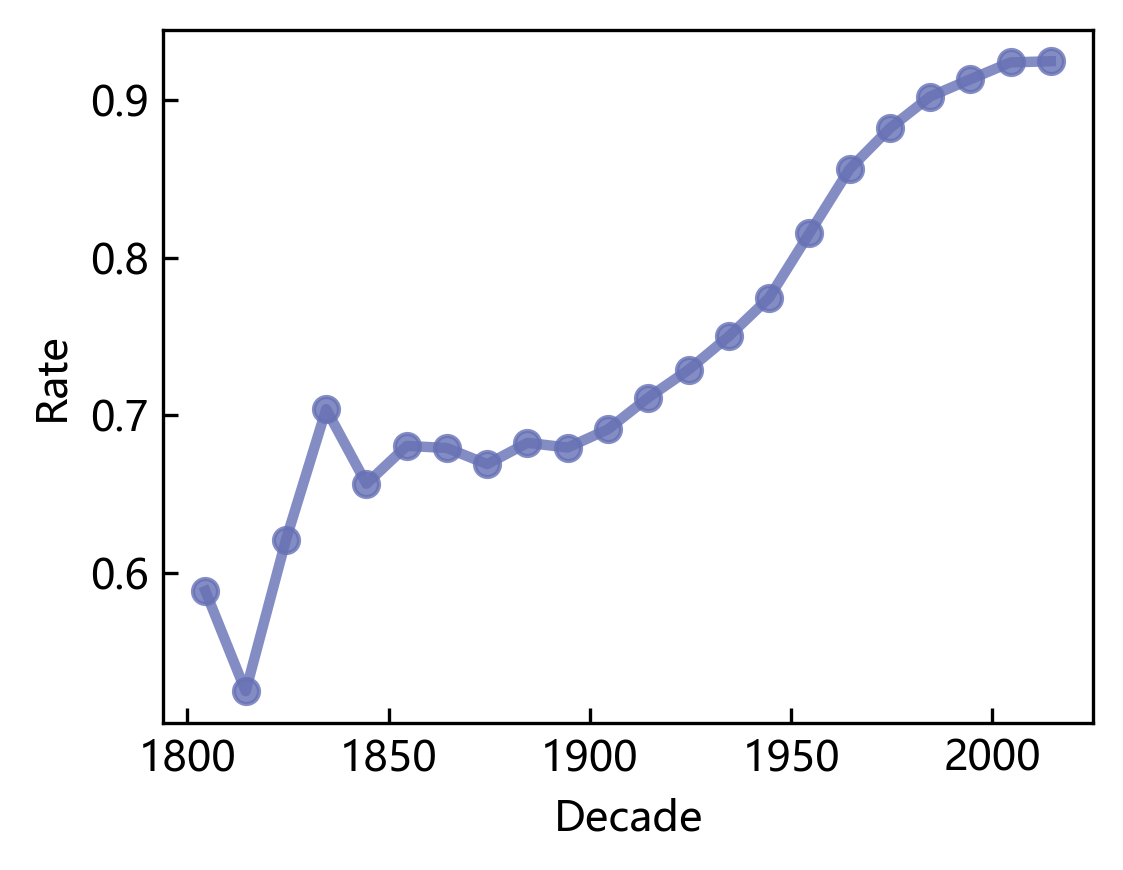

In [11]:
fig, axs = plt.subplots(figsize=(4, 3))

years = list(range(1800, 2020))
sliced_year = [years[k:k+10] for k in range(0, len(years), 10)]
X_, Y_ = [], []
rates = get_rates_per_10()
for ys, rate in zip(sliced_year, rates):
    X_.append(np.median(ys))
    Y_.append(rate)
    if rate > 0.8:
        print(ys, rate)
plt.plot(X_, Y_, color='#6671b5', linewidth=2.5, alpha=0.8, marker='o', markersize=6)

plt.xlabel('Decade')
plt.ylabel('Rate')

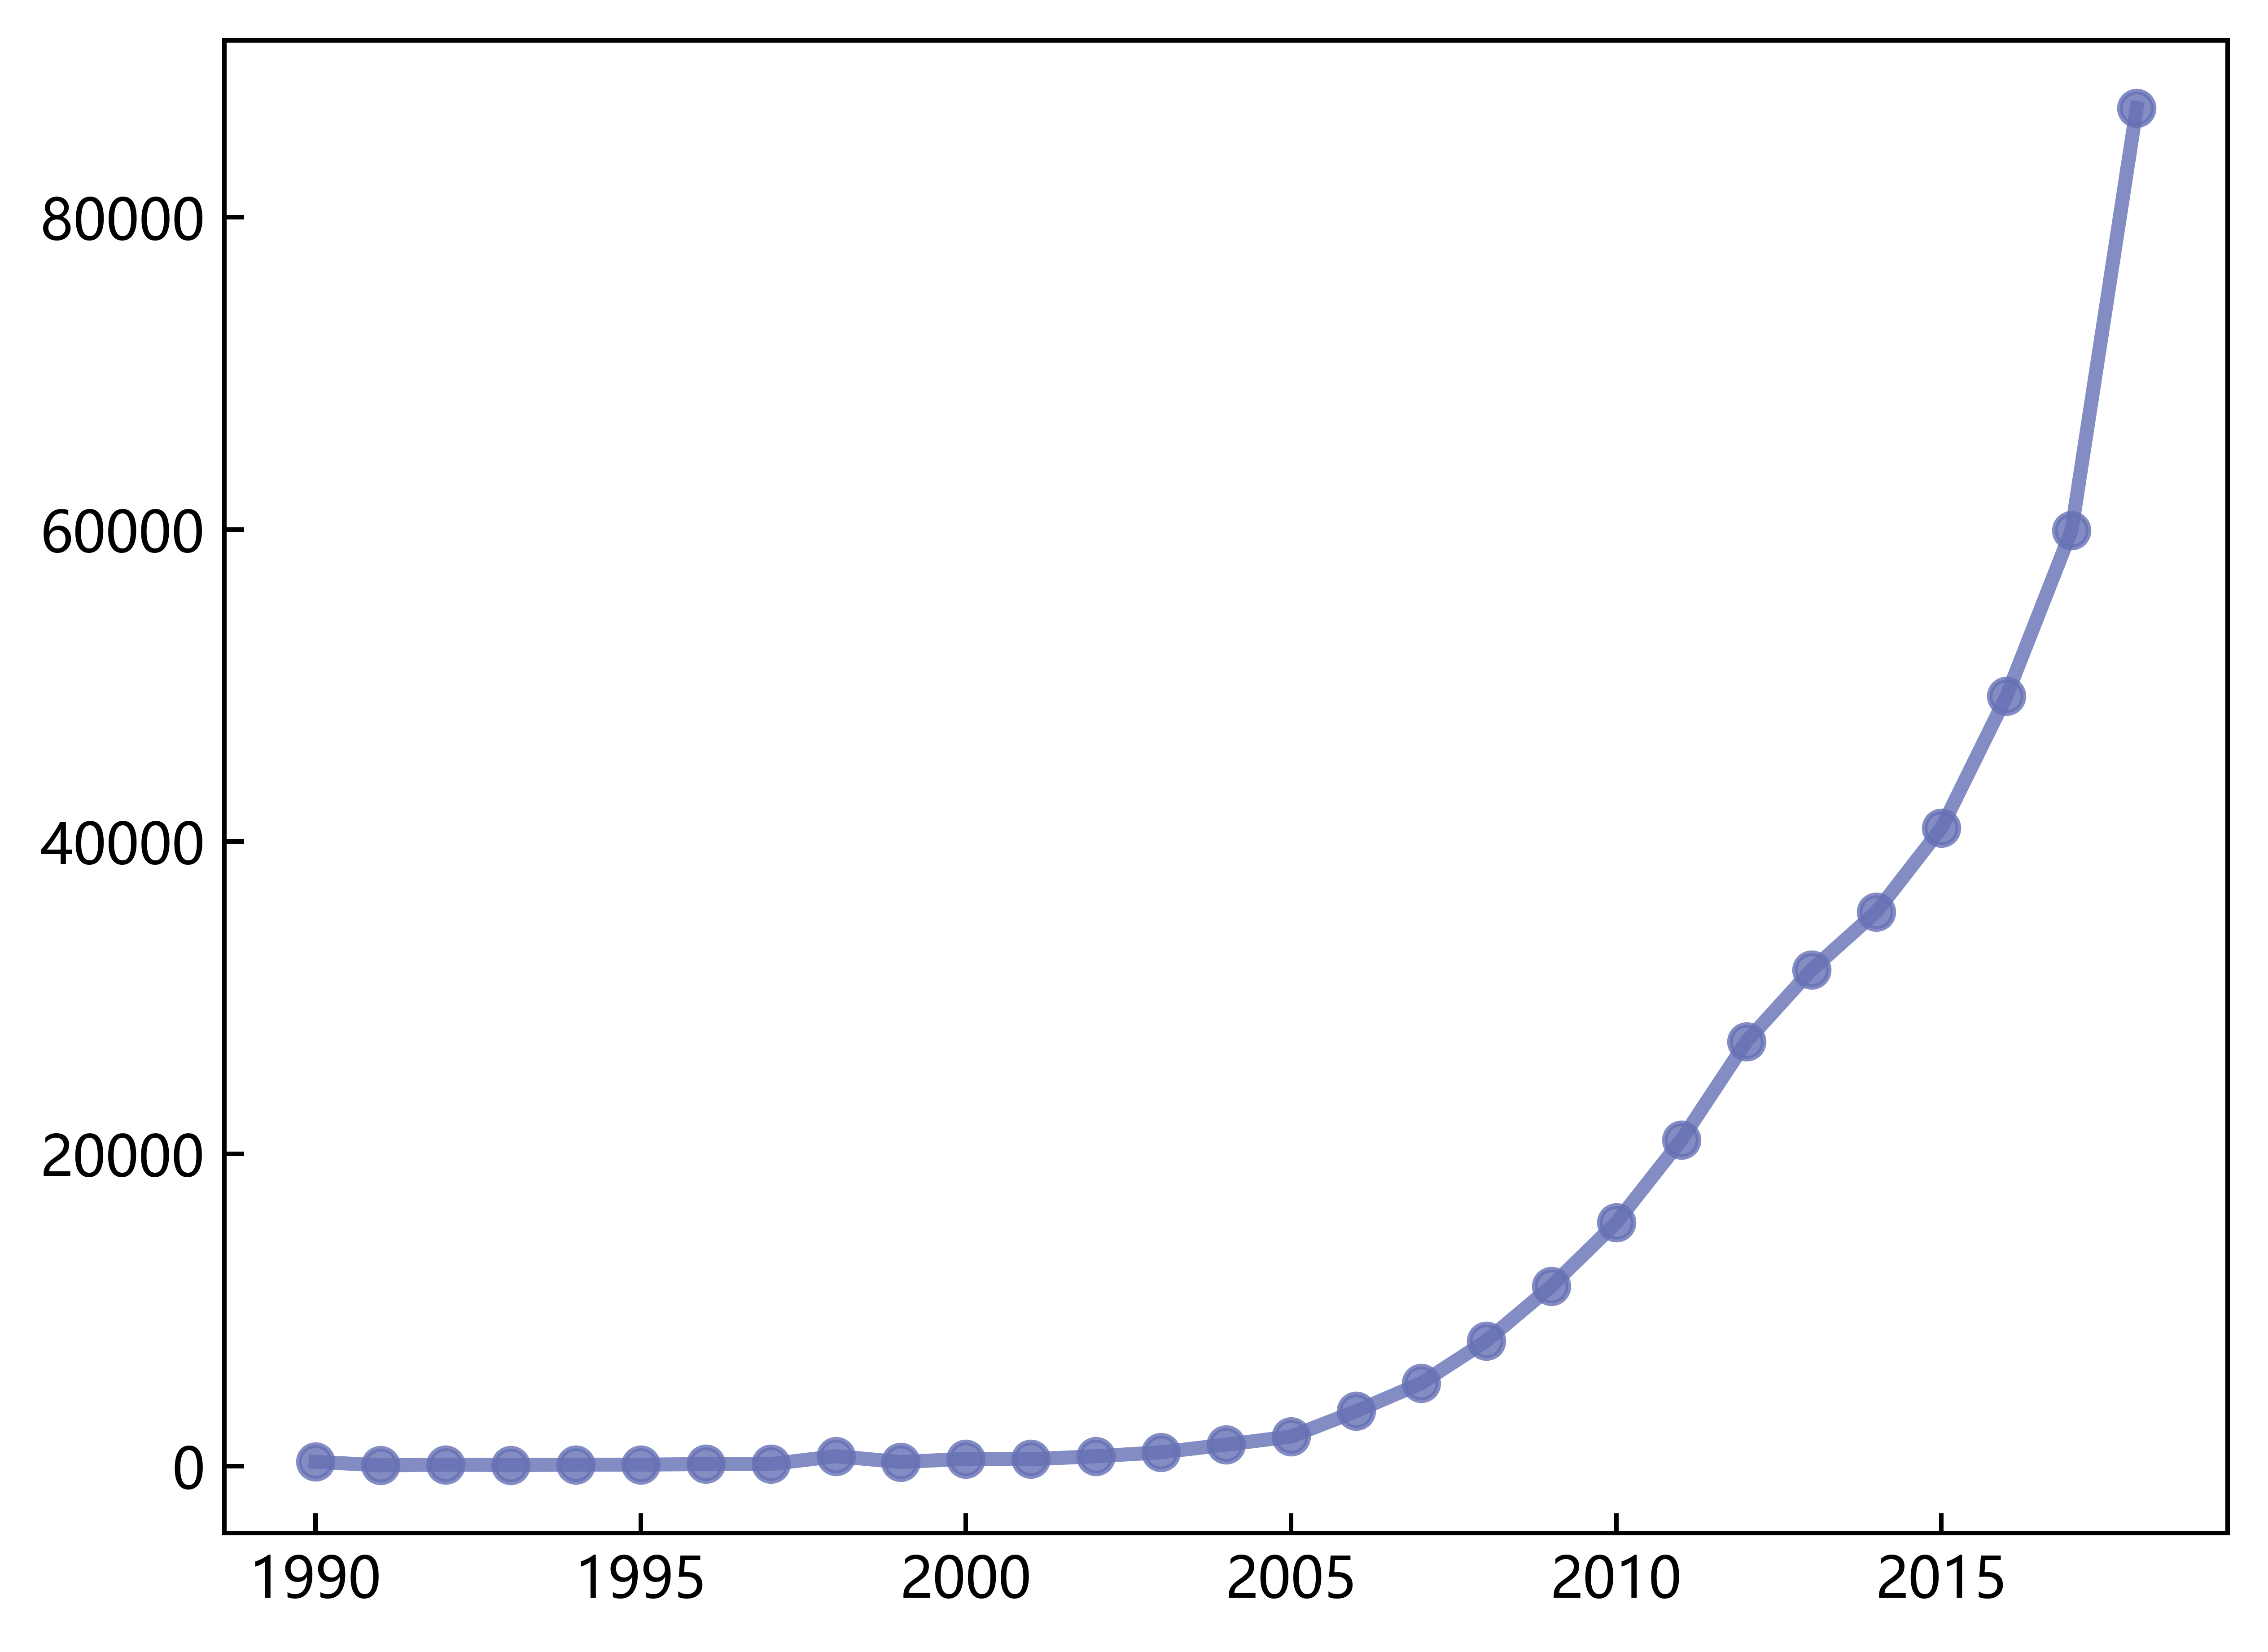

In [7]:
number_of_year = {'years': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
 'counts': [272, 47, 88, 60, 86, 90, 131, 131, 629, 256, 465, 438, 628, 878, 1373, 1893, 3514, 5304, 8013, 11519, 15595, 20890, 27190, 31774, 35506, 40878, 49328, 59938, 86979]}

X_, Y_ = [], []
for x, y in zip(number_of_year['years'], number_of_year['counts']):
    # if y < 1e4:
    #     continue
    X_.append(x)
    Y_.append(y)

# plt.yscale('log')
plt.plot(X_, Y_, color='#6671b5', linewidth=2.5, alpha=0.8, marker='o', markersize=6)